In [1]:
from scipy.stats import pearsonr, spearmanr
# import tensorflow as tf
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from concurrent.futures import ProcessPoolExecutor
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks



In [51]:
# utils


def lag_diff(x, n=1):
    """
    Compute the lag-n difference: x_i - x_{i-n}
    
    Parameters:
    - x: 1D array-like input
    - n: lag (positive integer), e.g., n=2 computes x[i] - x[i-2]
    
    Returns:
    - A NumPy array of length len(x) - n
    """
    x = np.asarray(x)
    if n < 1 or n >= len(x):
        raise ValueError("n must be >= 1 and less than the length of x")
    return x[n:] - x[:-n]



def trim_and_calculate_mean(array_list):
    # Find the minimum length among all arrays
    min_length = min(len(arr) for arr in array_list)
    
    # Trim each array to the minimum length
    trimmed_arrays = [arr[:min_length] for arr in array_list]
    
    # Convert to a NumPy array for vectorized mean calculation
    trimmed_arrays = np.array(trimmed_arrays)
    
    return trimmed_arrays


def seasonal_decompose_time_series(time_series, freq=None, model='additive', plot=True):
    """
    Decomposes the time series into trend, seasonal, and residual components.

    Parameters:
    - time_series: pandas Series with datetime index.
    - freq: The number of periods in a season (e.g., 12 for monthly data with yearly seasonality).
    - model: 'additive' or 'multiplicative' model for decomposition.
    - plot: If True, it will plot the components.

    Returns:
    - trend, seasonal, and residual components of the time series.
    """
    if isinstance(time_series, (np.ndarray, list)):
        time_series = pd.Series(time_series)
        
    # Ensure the time_series is a pandas Series with datetime index
    if not isinstance(time_series, pd.Series):
        raise ValueError("Input data must be a pandas Series.")
    
    if freq is None:
        raise ValueError("Please specify the frequency of the data (e.g., 12 for monthly data).")
    
    # Decompose the time series
    decomposition = seasonal_decompose(time_series, model=model, period=freq)
    
    # Plot the components if required
    if plot:
        plt.figure(figsize=(10, 8))
        plt.subplot(411)
        plt.plot(time_series, label='Original')
        plt.legend(loc='best')
        plt.title('Original Time Series')
        
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend(loc='best')
        plt.title('Trend Component')
        
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonal')
        plt.legend(loc='best')
        plt.title('Seasonal Component')
        
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residual')
        plt.legend(loc='best')
        plt.title('Residual Component')
        
        plt.tight_layout()
        plt.show()
    
    return decomposition.trend, decomposition.seasonal, decomposition.resid


def detect_periodicity_peaks(time_series):
    """
    Detects periodicity by identifying peaks in the time series.
    
    Parameters:
    - time_series: pandas Series or numpy array with datetime index.
    """
    if isinstance(time_series, (np.ndarray, list)):
        time_series = pd.Series(time_series)
    
    # # Ensure it has a datetime index
    # if not isinstance(time_series.index, pd.DatetimeIndex):
    #     raise ValueError("Time series must have a datetime index.")
    
    # Find peaks in the time series
    peaks, _ = find_peaks(time_series)
    
    # Estimate period based on the distance between peaks
    periods = np.diff(peaks)
    estimated_period = np.mean(periods)  # Average period
    
    print(f"Detected estimated period: {estimated_period} time units")
    
    # Plot the peaks
    plt.plot(time_series)
    plt.plot(time_series.index[peaks], time_series.iloc[peaks], 'ro', label='Peaks')
    plt.legend()
    plt.show()

    
def preprocess_checkpoints(folders_set):
    collective_transgressions_set = []
    collective_authoritarianism_set = []
    collective_d_prime_set = []
    for folders in folders_set:
        collective_authoritarianism = [[] for _ in range(len(folders))]
        collective_transgressions = [[] for _ in range(len(folders))]
        collective_d_prime = [[] for _ in range(len(folders))]
        collective_coin = [[] for _ in range(len(folders))]
        collective_gem= [[] for _ in range(len(folders))]
        for ixs, folder in enumerate(folders):
            parent_dir = os.path.join(os.getcwd()+'/res', folder)
            files = os.listdir(parent_dir)

            for f in files:
                if 'state_punishment_level_avg' in f:
                # if 'd_prime' in f:
                    data = pd.read_csv(os.path.join(parent_dir, f))
                    collective_authoritarianism[ixs].append(data['Value'].to_numpy()[:])
                if 'Bone' in f:
                    sub_dir = os.path.join(parent_dir, f)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))
                    collective_transgressions[ixs].append(data['Value'].to_numpy()[:])
                if 'Gem' in f:
                    sub_dir = os.path.join(parent_dir, f)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))
                    collective_gem[ixs].append(data['Value'].to_numpy()[:])
                if 'Coin' in f:
                    sub_dir = os.path.join(parent_dir, f)
                    file = os.listdir(sub_dir)[0]
                    data = pd.read_csv(os.path.join(sub_dir, file))
                    collective_coin[ixs].append(data['Value'].to_numpy()[:])
                if 'd_prime' in f:
                    data = pd.read_csv(os.path.join(parent_dir, f))
                    collective_d_prime[ixs].append(data['Value'].to_numpy()[:])

        collective_authoritarianism_ = [np.mean(trim_and_calculate_mean(collective_authoritarianism[i]), axis=0) 
                        for i in range(len(collective_authoritarianism))]
        collective_transgressions_ = [np.mean(trim_and_calculate_mean(collective_transgressions[i]), axis=0) 
                        for i in range(len(collective_transgressions))]
        collective_d_prime_ = [np.mean(trim_and_calculate_mean(collective_d_prime[i]), axis=0) 
                        for i in range(len(collective_d_prime))]
        collective_gem_ = [np.mean(trim_and_calculate_mean(collective_gem[i]), axis=0) 
                        for i in range(len(collective_gem))]
        collective_coin_ = [np.mean(trim_and_calculate_mean(collective_coin[i]), axis=0) 
                        for i in range(len(collective_coin))]
        
        collective_d_prime_set.append(collective_d_prime_)
        collective_transgressions_set.append(collective_transgressions_)
        collective_authoritarianism_set.append(collective_authoritarianism_)

    return collective_transgressions_set, collective_authoritarianism_set, collective_d_prime_set


def rolling_correlation(arr1, arr2, window_size):
    """
    Calculate the rolling Pearson correlation and p-values between two arrays.

    Parameters:
    arr1 (array-like): First input array.
    arr2 (array-like): Second input array.
    window_size (int): Size of the rolling window.

    Returns:
    tuple: A tuple containing two lists:
        - correlation_coeffs: The Pearson correlation coefficients for each window.
        - p_values: The p-values for each window.
    """
    # Check if arrays are the same length
    if len(arr1) != len(arr2):
        raise ValueError("Input arrays must have the same length.")
    
    # Initialize lists to store correlation coefficients and p-values
    correlation_coeffs = []
    p_values = []
    
    # Perform rolling correlation
    for i in range(len(arr1) - window_size + 1):
        window_arr1 = arr1[i:i + window_size]
        window_arr2 = arr2[i:i + window_size]
        
        # Calculate the Pearson correlation and p-value for the window
        corr, p_val = spearmanr(window_arr1, window_arr2)
        # print(i)
        # Append the results to the lists
        correlation_coeffs.append(corr)
        p_values.append(p_val)
    
    return correlation_coeffs, p_values


def chain_data_of_diff_checkpoints(array):
    chained_array = [[np.array(list(itertools.chain(*agent_condition_data))) for agent_condition_data in condition_data]
                        for condition_data in array]
    return chained_array

def plot_corr_across_time(cors, pvals):
    cors = list(itertools.chain(*cors))
    p_vals = list(itertools.chain(*pvals))

    # Create an array of indices for the x-axis
    x = np.arange(len(cors))

    # Plot the correlation coefficients
    plt.figure(figsize=(10, 6))

    # Plot the line plot of correlation coefficients
    plt.plot(x, cors, label="Rolling Pearson Correlation", color='gray', alpha=1)

    # Use a condition to color the points based on p-values
    colors = ['red' if p < 0.05 else 'blue' for p in p_vals]

    # Scatter plot the correlation coefficients, color-coded by p-values
    plt.scatter(x, cors, c=colors, s=5, marker='d', alpha=0.3)

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Spearmanr Correlation Coefficient")
    plt.title("Rolling Correlation Coefficients (Line & Colored Scatter)")

    # Optionally, add a horizontal line at 0 for better visualization
    plt.axhline(0, color='black', linewidth=1, linestyle='dotted')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


In [13]:
def preprocess_checkpoints_v2(folders_set, transgression_entities=None, all_entities=None):

    collective_transgressions_set = []
    collective_authoritarianism_set = []
    collective_all_entities_set = {e: [] for e in all_entities}

    for folders in folders_set:
        collective_authoritarianism = [[] for _ in range(len(folders))]
        collective_transgressions = [[] for _ in range(len(folders))]
        collective_all_entities = {e: [[] for _ in range(len(folders))] for e in all_entities}
       
        for ixs, folder in enumerate(folders):
            parent_dir = os.path.join(os.getcwd()+'/res', folder)
            files = os.listdir(parent_dir)

            for f in files:
                if 'state_punishment_level_avg' in f:
                # if 'd_prime' in f:
                    data = pd.read_csv(os.path.join(parent_dir, f))
                    collective_authoritarianism[ixs].append(data['Value'].to_numpy()[:])
                for e in transgression_entities:
                    if e in f:
                        sub_dir = os.path.join(parent_dir, f)
                        file = os.listdir(sub_dir)[0]
                        data = pd.read_csv(os.path.join(sub_dir, file))
                        collective_transgressions[ixs].append(data['Value'].to_numpy()[:])
                for e in all_entities:
                    if e in f:
                        sub_dir = os.path.join(parent_dir, f)
                        file = os.listdir(sub_dir)[0]
                        data = pd.read_csv(os.path.join(sub_dir, file))
                        collective_all_entities[e][ixs].append(data['Value'].to_numpy()[:])
                

        collective_authoritarianism_ = [np.mean(trim_and_calculate_mean(collective_authoritarianism[i]), axis=0) 
                        for i in range(len(collective_authoritarianism))]
        collective_transgressions_ = [np.mean(trim_and_calculate_mean(collective_transgressions[i]), axis=0) 
                        for i in range(len(collective_transgressions))]

        collective_all_entities_ = {e: [np.mean(trim_and_calculate_mean(collective_all_entities[e][i]), axis=0) 
                        for i in range(len(collective_all_entities[e]))] for e in all_entities}
        
        
        collective_transgressions_set.append(collective_transgressions_)
        collective_authoritarianism_set.append(collective_authoritarianism_)
        for e in all_entities:
            collective_all_entities_set[e].append(collective_all_entities_[e])

    return collective_transgressions_set, collective_authoritarianism_set, collective_all_entities_set

In [ ]:
folders = [
    'Study1_experiment_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250507-18051746658070',
    # "Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250603-11061748963658"
    # 'Study1_control_only_taboo_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250522-16051747946616',
    # 'Study1_control_only_taboo_transfer_from_exp_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250526-21051748308104'
]

collective_authoritarianism = [[] for _ in range(len(folders))]
collective_transgressions = [[] for _ in range(len(folders))]
collective_d_prime = [[] for _ in range(len(folders))]
collective_coin = [[] for _ in range(len(folders))]
collective_gem= [[] for _ in range(len(folders))]

for ixs, folder in enumerate(folders):
    parent_dir = os.path.join(os.getcwd()+'/res', folder)
    files = os.listdir(parent_dir)

    for f in files:
        if 'state_punishment_level_avg' in f:
        # if 'd_prime' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_authoritarianism[ixs].append(data['Value'].to_numpy()[:])
        if 'Bone' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective_transgressions[ixs].append(data['Value'].to_numpy()[:])
        if 'Gem' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective_gem[ixs].append(data['Value'].to_numpy()[:])
        if 'Coin' in f:
            sub_dir = os.path.join(parent_dir, f)
            file = os.listdir(sub_dir)[0]
            data = pd.read_csv(os.path.join(sub_dir, file))
            collective_coin[ixs].append(data['Value'].to_numpy()[:])
        if 'd_prime' in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            collective_d_prime[ixs].append(data['Value'].to_numpy()[:])

collective_authoritarianism_ = [np.mean(trim_and_calculate_mean(collective_authoritarianism[i]), axis=0) 
                  for i in range(len(collective_authoritarianism))]
collective_transgressions_ = [np.mean(trim_and_calculate_mean(collective_transgressions[i]), axis=0) 
                  for i in range(len(collective_transgressions))]
collective_d_prime_ = [np.mean(trim_and_calculate_mean(collective_d_prime[i]), axis=0) 
                  for i in range(len(collective_d_prime))]
collective_gem_ = [np.mean(trim_and_calculate_mean(collective_gem[i]), axis=0) 
                  for i in range(len(collective_gem))]
collective_coin_ = [np.mean(trim_and_calculate_mean(collective_coin[i]), axis=0) 
                  for i in range(len(collective_coin))]


In [ ]:
folders = [
    'Study1_experiment_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250507-18051746658070',
    # "Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250603-11061748963658"
    # 'Study1_control_only_taboo_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250522-16051747946616',
    # 'Study1_control_only_taboo_transfer_from_exp_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250526-21051748308104'
]
folders_1 = folders
folders_set = [folders]

agents_num = [3, 3, 3, 3] # specify the number of agents in each condition

collective_authoritarianism = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]
collective_transgressions = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]
collective_d_prime = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]
collective_coin = [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]
collective_gem= [[[] for _ in range(agents_num[folder_ixs])] for folder_ixs in range(len(folders_1))]

for folders in folders_set:
    for ixs, folder in enumerate(folders):
        if folder != '':
            parent_dir = os.path.join(os.getcwd()+'/res', folder)
            files = os.listdir(parent_dir)

            for f in files:
                for a in range(len(collective_authoritarianism[ixs])):
                            if 'state_punishment_level_avg' in f:
                                    data = pd.read_csv(os.path.join(parent_dir, f))
                                    collective_authoritarianism[ixs][a].append(data['Value'].to_numpy()[:])
                            if 'd_prime' in f:
                                    data = pd.read_csv(os.path.join(parent_dir, f))
                                    collective_d_prime[ixs][a].append(data['Value'].to_numpy()[:])
                            if f'Agent_{a}' in f:
                                if 'Bone' in f:
                                    sub_dir = os.path.join(parent_dir, f)
                                    file = os.listdir(sub_dir)[0]
                                    data = pd.read_csv(os.path.join(sub_dir, file))
                                    collective_transgressions[ixs][a].append(data['Value'].to_numpy()[:])
                                if 'Gem' in f:
                                    sub_dir = os.path.join(parent_dir, f)
                                    file = os.listdir(sub_dir)[0]
                                    data = pd.read_csv(os.path.join(sub_dir, file))
                                    collective_gem[ixs][a].append(data['Value'].to_numpy()[:])
                                if 'Coin' in f:
                                    sub_dir = os.path.join(parent_dir, f)
                                    file = os.listdir(sub_dir)[0]
                                    data = pd.read_csv(os.path.join(sub_dir, file))
                                    collective_coin[ixs][a].append(data['Value'].to_numpy()[:])
                            

collective_authoritarianism = chain_data_of_diff_checkpoints(collective_authoritarianism)
collective_transgressions = chain_data_of_diff_checkpoints(collective_transgressions)
collective_d_prime = chain_data_of_diff_checkpoints(collective_d_prime)
collective_gem = chain_data_of_diff_checkpoints(collective_gem)
collective_coin = chain_data_of_diff_checkpoints(collective_coin)

collective_authoritarianism_ = [np.mean(trim_and_calculate_mean(collective_authoritarianism[i]), axis=0) 
                  for i in range(len(collective_authoritarianism))]
collective_transgressions_ = [np.mean(trim_and_calculate_mean(collective_transgressions[i]), axis=0) 
                  for i in range(len(collective_transgressions))]
collective_d_prime_ = [np.mean(trim_and_calculate_mean(collective_d_prime[i]), axis=0) 
                  for i in range(len(collective_d_prime))]
collective_gem_ = [np.mean(trim_and_calculate_mean(collective_gem[i]), axis=0) 
                  for i in range(len(collective_gem))]
collective_coin_ = [np.mean(trim_and_calculate_mean(collective_coin[i]), axis=0) 
                  for i in range(len(collective_coin))]

In [71]:
endpoint = 75446
startpoint = 0
folder_ixs = 0
diff_authoritarianism = np.diff(collective_authoritarianism_[folder_ixs][startpoint:endpoint])
diff_d_prime = np.diff(collective_d_prime_[folder_ixs][startpoint:endpoint])
# print(len(diff_authoritarianism), collective_transgressions_[folder_ixs][:endpoint].shape)

print('transgression ~ diff authoritarianism')
print(spearmanr(collective_transgressions_[folder_ixs][startpoint:endpoint-1], diff_authoritarianism),'\n');

print('transgression ~ d-prime diff')
print(spearmanr(collective_transgressions_[folder_ixs][startpoint:endpoint-1][-1000:], diff_d_prime[-1000:]));


transgression ~ diff authoritarianism
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
SignificanceResult(statistic=0.13264664951549512, pvalue=3.360469269191529e-293) 

transgression ~ d-prime diff
SignificanceResult(statistic=-0.34036638704860056, pvalue=1.5264847587809e-28)
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
print('transgression+good acts ~ d-prime diff')
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Sample data
data = {
    'X1': collective_transgressions_[folder_ixs][:endpoint-1],
    'X2': collective_coin_[folder_ixs][:endpoint-1],
    'X3': collective_gem_[folder_ixs][:endpoint-1],
    'Y': diff_authoritarianism
}

df = pd.DataFrame(data)

# Define independent variables (X) and dependent variable (Y)
X = df[['X1', 'X2', 'X3']]  # Independent variables
Y = df['Y']           # Dependent variable

# Create the regression model
model = LinearRegression()

# Fit the model on the entire dataset
model.fit(X, Y)

# Make predictions on the same data
Y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(Y, Y_pred)
r2 = r2_score(Y, Y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Print coefficients and intercept
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

In [ ]:
folder_ixs = 0
min_len = min(len(collective_transgressions_[folder_ixs]), len(collective_d_prime_[folder_ixs]))
if len(collective_transgressions_[folder_ixs]) > min_len:
    transgression_level = collective_transgressions_[folder_ixs][:min_len]
    diff_authoritarianism = np.diff(collective_authoritarianism_[folder_ixs][:])
    diff_d_prime = np.diff(collective_d_prime_[folder_ixs][:])
else:
    d_prime_truncated = collective_d_prime_[folder_ixs][:min_len]
    diff_d_prime = np.diff(d_prime_truncated)
    state_punishment_leve = np.diff(collective_authoritarianism_[folder_ixs][:min_len])
    transgression_level = collective_transgressions_[folder_ixs][:]

cors_, p_vals = rolling_correlation(
    transgression_level[:-1], 
    diff_d_prime,
    1000)
# plt.plot(cors_)

chain multiple checkpoints

In [ ]:
folders_1 = [
    'Study1_experiment_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250507-18051746658070',
    # "Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250603-11061748963658"
    # 'Study1_control_only_taboo_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250522-16051747946616',
    # 'Study1_control_only_taboo_transfer_from_exp_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250526-21051748308104'
]

folders_set = [folders_1]
folder_ixs = 0

collective_transgressions_set, collective_authoritarianism_set, collective_d_prime_set = preprocess_checkpoints(
    folders_set
)

cors_lst, p_vals_lst = [], []
for i in range(len(folders_set)):
    collective_transgressions_ = collective_transgressions_set[i]
    collective_authoritarianism_ = collective_authoritarianism_set[i]
    collective_d_prime_ = collective_d_prime_set[i]
    min_len = min(len(collective_transgressions_[folder_ixs]), len(collective_d_prime_[folder_ixs]))
    if len(collective_transgressions_[folder_ixs]) > min_len:
        transgression_level = collective_transgressions_set[i][folder_ixs][:min_len]
        diff_authoritarianism = np.diff(collective_authoritarianism_set[i][folder_ixs][:])
        diff_d_prime = np.diff(collective_d_prime_set[i][folder_ixs][:])
    else:
        d_prime_truncated = collective_d_prime_set[i][folder_ixs][:min_len]
        diff_d_prime = np.diff(d_prime_truncated)
        state_punishment_leve = np.diff(collective_authoritarianism_set[i][folder_ixs][:min_len])
        transgression_level = collective_transgressions_set[i][folder_ixs][:]

    cors_, p_vals = rolling_correlation(
        transgression_level[:-1], 
        diff_d_prime,
        1000)
    cors_lst.append(cors_)
    p_vals_lst.append(p_vals)

In [47]:
len(diff_transgression_level), len(transgression_level), len(diff_state_punishment_level), len(state_punishment_level), min_len

(63319, 63320, 63322, 63320, 63320)

In [58]:
folders_1 = [
    # 'Study1_experiment_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250507-18051746658070',
    "Study1_experiment_cond_v2_improved_punishment_scheme_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250603-11061748963658"
    # 'Study1_control_only_taboo_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250522-16051747946616',
    # 'Study1_control_only_taboo_transfer_from_exp_cond_stacked_view_simple_actions_3agents_respawn_0.04_s1_r1_seed3_20250526-21051748308104'
]

folders_set = [folders_1]
folder_ixs = 0

collective_transgressions_set, collective_authoritarianism_set, collective_all_entities_set = preprocess_checkpoints_v2(
    folders_set,
    transgression_entities=['Encounters_E'],
    all_entities=['Encounters_A', 'Encounters_B', 'Encounters_C', 'Encounters_D', 'Encounters_E']
)

lag_n = 1

cors_lst, p_vals_lst = [], []
for i in range(len(folders_set)):
    collective_transgressions_ = collective_transgressions_set[i]
    collective_authoritarianism_ = collective_authoritarianism_set[i]
    min_len = min(len(collective_transgressions_[folder_ixs]), len(collective_authoritarianism_[folder_ixs]))

    base_metric = [collective_transgressions_, collective_authoritarianism_][1]
    if len(base_metric[folder_ixs]) > min_len:
        transgression_level = collective_transgressions_set[i][folder_ixs][:min_len]
        state_punishment_level = collective_authoritarianism_set[i][folder_ixs][:min_len]
        diff_transgression_level = lag_diff(collective_transgressions_set[i][folder_ixs][:], lag_n) 
        diff_state_punishment_level = lag_diff(collective_authoritarianism_set[i][folder_ixs][:], lag_n)
    else:
        diff_transgression_level = lag_diff(collective_transgressions_set[i][folder_ixs][:min_len], lag_n)
        diff_state_punishment_level = lag_diff(collective_authoritarianism_set[i][folder_ixs][:min_len], lag_n)
        transgression_level = collective_transgressions_set[i][folder_ixs][:]
        state_punishment_level = collective_authoritarianism_set[i][folder_ixs][:]

    # cors_, p_vals = rolling_correlation(
    #     transgression_level[:-1], 
    #     diff_state_punishment_level,
    #     1000)

    cors_, p_vals = rolling_correlation(
        state_punishment_level[:-lag_n], 
        diff_transgression_level,
        1000)
    cors_lst.append(cors_)
    p_vals_lst.append(p_vals)

In [ ]:
cors = list(itertools.chain(*cors_lst))
p_vals = list(itertools.chain(*p_vals_lst))

# Create an array of indices for the x-axis
x = np.arange(len(cors))

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))

# Plot the line plot of correlation coefficients
plt.plot(x, cors, label="Rolling Pearson Correlation", color='gray', alpha=1)

# Use a condition to color the points based on p-values
colors = ['red' if p < 0.05 else 'blue' for p in p_vals]

# Scatter plot the correlation coefficients, color-coded by p-values
plt.scatter(x, cors, c=colors, label="Significant Correlations (p < 0.05)", s=5, marker='d', alpha=0.3)

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Spearmanr Correlation Coefficient")
plt.title("Rolling Correlation Coefficients (Line & Colored Scatter)")

# Optionally, add a horizontal line at 0 for better visualization
plt.axhline(0, color='black', linewidth=1, linestyle='dotted')

# Add a legend
plt.legend()

# Show the plot
plt.show()

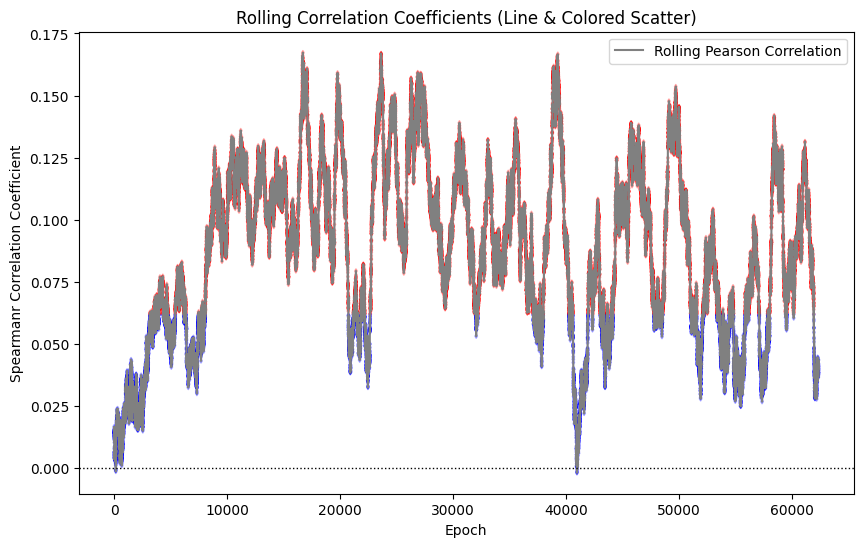

In [59]:
plot_corr_across_time(cors_lst, p_vals_lst)

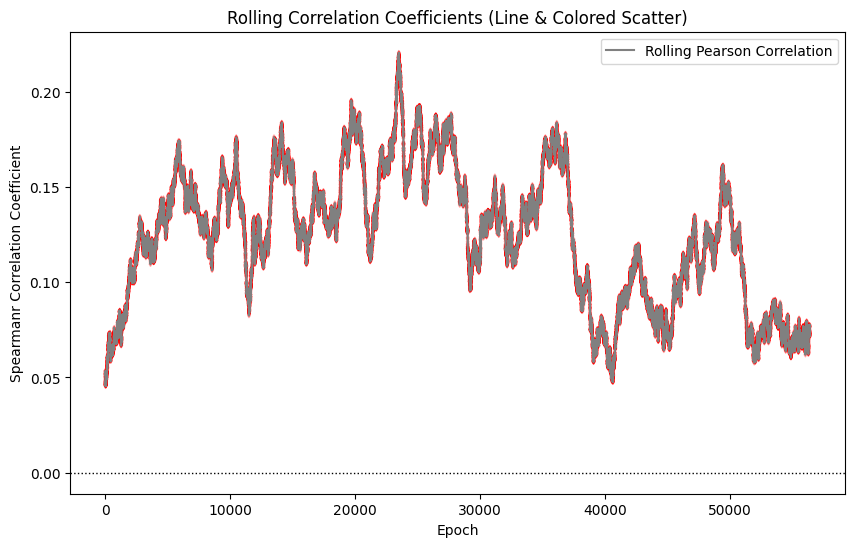

In [24]:
plot_corr_across_time(cors_lst, p_vals_lst)

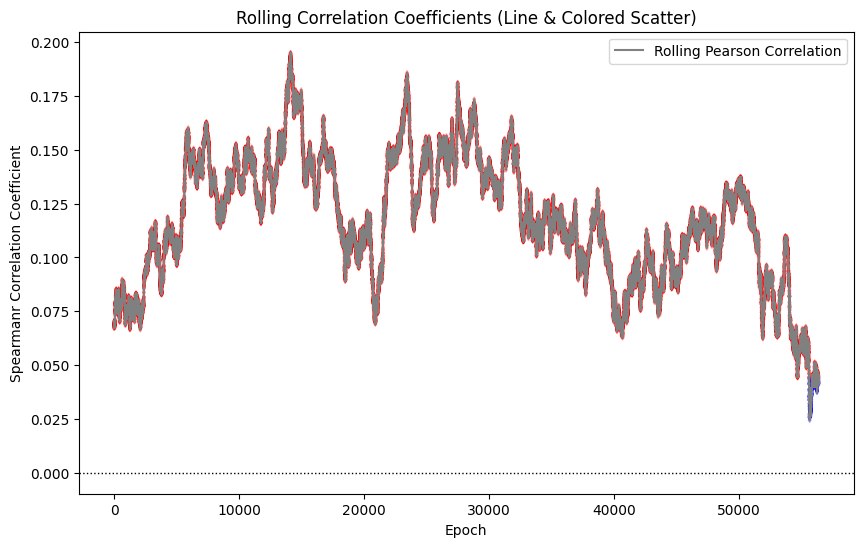

In [28]:
plot_corr_across_time(cors_lst, p_vals_lst)

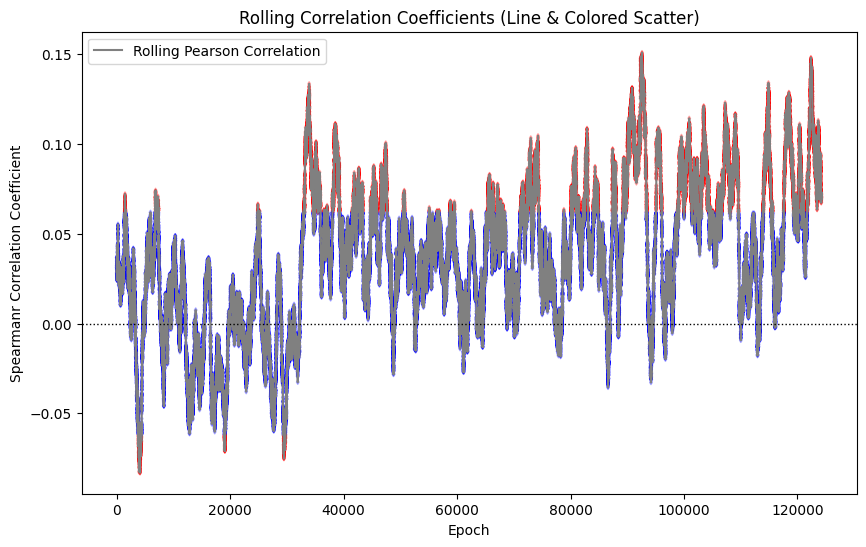

In [153]:
plot_corr_across_time(cors_lst, p_vals_lst)